# AI Text Detection - Heuristic Models

This notebook trains multiple machine learning models to detect AI-generated text using heuristic features.


## Part 1: Naîve Features and Traditional heuristic ML methods

In [9]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [10]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (269, 4)
Test shape: (264, 3)


## Feature Engineering Functions


In [11]:
def extract_text_features(df):
    """
    Extract comprehensive text-based features from the answer column.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'answer' column
        
    Returns:
    -------
    pd.DataFrame
        DataFrame with additional feature columns
    """
    df = df.copy()
    
    # Basic text statistics
    df['text_length'] = df['answer'].str.len()
    df['word_count'] = df['answer'].str.split().str.len()
    df['char_count_no_spaces'] = df['answer'].str.replace(' ', '').str.len()
    df['sentence_count'] = df['answer'].str.count(r'[.!?]+')
    df['paragraph_count'] = df['answer'].str.count('\n\n') + 1
    
    # Average word length
    df['avg_word_length'] = df['char_count_no_spaces'] / (df['word_count'] + 1e-6)
    
    # Average sentence length
    df['avg_sentence_length'] = df['word_count'] / (df['sentence_count'] + 1e-6)
    
    # Punctuation features (escaping special regex characters)
    df['exclamation_count'] = df['answer'].str.count('!')
    df['question_count'] = df['answer'].str.count(r'\?')
    df['comma_count'] = df['answer'].str.count(',')
    df['period_count'] = df['answer'].str.count(r'\.')
    df['punctuation_ratio'] = (df['exclamation_count'] + df['question_count'] + df['period_count']) / (df['text_length'] + 1e-6)
    
    # Capitalization features
    df['uppercase_count'] = df['answer'].str.findall(r'[A-Z]').str.len()
    df['uppercase_ratio'] = df['uppercase_count'] / (df['text_length'] + 1e-6)
    
    # Special characters
    df['digit_count'] = df['answer'].str.count(r'\d')
    df['special_char_count'] = df['answer'].str.count(r'[^\w\s]')
    
    # Word complexity (long words)
    words = df['answer'].str.split()
    df['long_word_count'] = words.apply(lambda x: sum(1 for w in x if len(w) > 6))
    df['long_word_ratio'] = df['long_word_count'] / (df['word_count'] + 1e-6)
    
    # Common AI indicators (case-insensitive using findall)
    df['first_person_pronouns'] = df['answer'].str.findall(r'(?i)\b(I|me|my|myself|we|us|our|ourselves)\b').str.len()
    df['first_person_ratio'] = df['first_person_pronouns'] / (df['word_count'] + 1e-6)
    
    # Whitespace features
    df['whitespace_count'] = df['answer'].str.count(' ')
    df['whitespace_ratio'] = df['whitespace_count'] / (df['text_length'] + 1e-6)
    
    # Unique word ratio (vocabulary diversity)
    df['unique_word_count'] = words.apply(lambda x: len(set(w.lower() for w in x)) if x else 0)
    df['unique_word_ratio'] = df['unique_word_count'] / (df['word_count'] + 1e-6)
    
    return df


In [12]:
def encode_topic(df, le=None, fit=True):
    """
    Encode topic column using LabelEncoder.
    Handles unseen topics in test set by mapping them to -1.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'topic' column
    le : LabelEncoder, optional
        Pre-fitted LabelEncoder. If None and fit=True, creates new one
    fit : bool
        Whether to fit the encoder (True for training, False for test)
        
    Returns:
    -------
    pd.DataFrame, LabelEncoder
        DataFrame with encoded topic and the encoder
    """
    df = df.copy()
    
    if le is None:
        le = LabelEncoder()
    
    if fit:
        df['topic_encoded'] = le.fit_transform(df['topic'])
    else:
        # Handle unseen topics by mapping them to -1
        known_topics = set(le.classes_)
        df['topic_encoded'] = df['topic'].apply(
            lambda x: le.transform([x])[0] if x in known_topics else -1
        )
    
    return df, le


In [13]:
def prepare_features(train_df, test_df=None):
    """
    Prepare features for training and testing.
    
    Parameters:
    -----------
    train_df : pd.DataFrame
        Training dataframe
    test_df : pd.DataFrame, optional
        Test dataframe
        
    Returns:
    -------
    tuple
        (X_train, y_train, X_test, feature_names, topic_encoder)
    """
    # Extract text features
    train_processed = extract_text_features(train_df)
    
    # Encode topics
    train_processed, topic_encoder = encode_topic(train_processed, fit=True)
    
    # Select feature columns (exclude id, topic, answer, is_cheating)
    feature_cols = [col for col in train_processed.columns 
                   if col not in ['id', 'topic', 'answer', 'is_cheating']]
    
    X_train = train_processed[feature_cols].values
    y_train = train_processed['is_cheating'].values
    
    X_test = None
    if test_df is not None:
        test_processed = extract_text_features(test_df)
        test_processed, _ = encode_topic(test_processed, le=topic_encoder, fit=False)
        X_test = test_processed[feature_cols].values
    
    return X_train, y_train, X_test, feature_cols, topic_encoder


## Model Evaluation Functions


In [14]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """
    Evaluate model performance with multiple metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_pred_proba : array-like, optional
        Predicted probabilities (for ROC-AUC)
    model_name : str
        Name of the model for display
        
    Returns:
    -------
    dict
        Dictionary of metrics
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Evaluation Metrics")
    print(f"{'='*60}")
    for metric, value in metrics.items():
        print(f"{metric.upper():15s}: {value:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Authentic', 'AI-assisted']))
    
    return metrics


In [15]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model", ax=None):
    """
    Plot confusion matrix.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    model_name : str
        Name of the model
    ax : matplotlib.axes, optional
        Axes to plot on
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Authentic', 'AI-assisted'],
                yticklabels=['Authentic', 'AI-assisted'])
    ax.set_title(f'{model_name} - Confusion Matrix', fontweight='bold', fontsize=12)
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    
    if ax is None:
        plt.tight_layout()
        plt.show()


In [16]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model", ax=None):
    """
    Plot ROC curve.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_proba : array-like
        Predicted probabilities
    model_name : str
        Name of the model
    ax : matplotlib.axes, optional
        Axes to plot on
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{model_name} - ROC Curve', fontweight='bold', fontsize=12)
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return auc_score


In [17]:
def plot_feature_importance(model, feature_names, model_name="Model", top_n=15, ax=None):
    """
    Plot feature importance.
    
    Parameters:
    -----------
    model : sklearn model
        Trained model with feature_importances_ attribute
    feature_names : list
        List of feature names
    model_name : str
        Name of the model
    top_n : int
        Number of top features to display
    ax : matplotlib.axes, optional
        Axes to plot on
    """
    if not hasattr(model, 'feature_importances_'):
        print(f"Model {model_name} does not have feature_importances_ attribute")
        return
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.barh(range(top_n), importances[indices], color='steelblue')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'{model_name} - Top {top_n} Feature Importances', fontweight='bold', fontsize=12)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    if ax is None:
        plt.tight_layout()
        plt.show()


In [18]:
def cross_validate_model(model, X, y, cv=5, scoring='roc_auc'):
    """
    Perform cross-validation on a model.
    
    Parameters:
    -----------
    model : sklearn model
        Model to cross-validate
    X : array-like
        Features
    y : array-like
        Labels
    cv : int
        Number of folds
    scoring : str
        Scoring metric
        
    Returns:
    -------
    dict
        Dictionary with CV results
    """
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    results = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"\nCross-Validation Results ({scoring}):")
    print(f"Mean: {results['mean']:.4f} (+/- {results['std']*2:.4f})")
    print(f"Individual fold scores: {cv_scores}")
    
    return results


## Prepare Features


In [19]:
# Prepare features
X_train, y_train, X_test, feature_names, topic_encoder = prepare_features(train, test)

print(f"Number of features: {len(feature_names)}")
print(f"\nFeature names:")
for i, name in enumerate(feature_names, 1):
    print(f"{i:2d}. {name}")


Number of features: 25

Feature names:
 1. text_length
 2. word_count
 3. char_count_no_spaces
 4. sentence_count
 5. paragraph_count
 6. avg_word_length
 7. avg_sentence_length
 8. exclamation_count
 9. question_count
10. comma_count
11. period_count
12. punctuation_ratio
13. uppercase_count
14. uppercase_ratio
15. digit_count
16. special_char_count
17. long_word_count
18. long_word_ratio
19. first_person_pronouns
20. first_person_ratio
21. whitespace_count
22. whitespace_ratio
23. unique_word_count
24. unique_word_ratio
25. topic_encoded


In [20]:
# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set size: {X_train_split.shape[0]}")
print(f"Validation set size: {X_val_split.shape[0]}")
print(f"Test set size: {X_test.shape[0] if X_test is not None else 0}")


Training set size: 215
Validation set size: 54
Test set size: 264


## Train Models


In [21]:
# Dictionary to store all models and their results
models = {}
results = {}


In [22]:
# 1. Random Forest
print("\n" + "="*60)
print("Training Random Forest")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Cross-validation
cv_results = cross_validate_model(rf_model, X_train_split, y_train_split, cv=5)

# Train on full training set
rf_model.fit(X_train_split, y_train_split)

# Predictions
y_pred_rf = rf_model.predict(X_val_split)
y_pred_proba_rf = rf_model.predict_proba(X_val_split)[:, 1]

# Evaluate
rf_metrics = evaluate_model(y_val_split, y_pred_rf, y_pred_proba_rf, "Random Forest")

# Store
models['Random Forest'] = rf_model
results['Random Forest'] = rf_metrics



Training Random Forest

Cross-Validation Results (roc_auc):
Mean: 0.9510 (+/- 0.0614)
Individual fold scores: [0.97391304 0.9673913  0.96086957 0.89035088 0.9627193 ]

Random Forest - Evaluation Metrics
ACCURACY       : 0.8889
PRECISION      : 0.9615
RECALL         : 0.8333
F1             : 0.8929
ROC_AUC        : 0.9201

Classification Report:
              precision    recall  f1-score   support

   Authentic       0.82      0.96      0.88        24
 AI-assisted       0.96      0.83      0.89        30

    accuracy                           0.89        54
   macro avg       0.89      0.90      0.89        54
weighted avg       0.90      0.89      0.89        54



In [23]:
# 2. XGBoost
print("\n" + "="*60)
print("Training XGBoost")
print("="*60)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Cross-validation
cv_results = cross_validate_model(xgb_model, X_train_split, y_train_split, cv=5)

# Train on full training set
xgb_model.fit(X_train_split, y_train_split)

# Predictions
y_pred_xgb = xgb_model.predict(X_val_split)
y_pred_proba_xgb = xgb_model.predict_proba(X_val_split)[:, 1]

# Evaluate
xgb_metrics = evaluate_model(y_val_split, y_pred_xgb, y_pred_proba_xgb, "XGBoost")

# Store
models['XGBoost'] = xgb_model
results['XGBoost'] = xgb_metrics



Training XGBoost

Cross-Validation Results (roc_auc):
Mean: 0.9620 (+/- 0.0572)
Individual fold scores: [0.95869565 0.98043478 0.97608696 0.90789474 0.98684211]

XGBoost - Evaluation Metrics
ACCURACY       : 0.8889
PRECISION      : 0.9615
RECALL         : 0.8333
F1             : 0.8929
ROC_AUC        : 0.9389

Classification Report:
              precision    recall  f1-score   support

   Authentic       0.82      0.96      0.88        24
 AI-assisted       0.96      0.83      0.89        30

    accuracy                           0.89        54
   macro avg       0.89      0.90      0.89        54
weighted avg       0.90      0.89      0.89        54



In [24]:
# 3. Logistic Regression (with scaling)
print("\n" + "="*60)
print("Training Logistic Regression")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='liblinear'
)

# Cross-validation
cv_results = cross_validate_model(lr_model, X_train_scaled, y_train_split, cv=5)

# Train on full training set
lr_model.fit(X_train_scaled, y_train_split)

# Predictions
y_pred_lr = lr_model.predict(X_val_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate
lr_metrics = evaluate_model(y_val_split, y_pred_lr, y_pred_proba_lr, "Logistic Regression")

# Store (with scaler)
models['Logistic Regression'] = {'model': lr_model, 'scaler': scaler}
results['Logistic Regression'] = lr_metrics



Training Logistic Regression

Cross-Validation Results (roc_auc):
Mean: 0.9284 (+/- 0.0520)
Individual fold scores: [0.94782609 0.93478261 0.91086957 0.88815789 0.96052632]

Logistic Regression - Evaluation Metrics
ACCURACY       : 0.8519
PRECISION      : 0.8667
RECALL         : 0.8667
F1             : 0.8667
ROC_AUC        : 0.9222

Classification Report:
              precision    recall  f1-score   support

   Authentic       0.83      0.83      0.83        24
 AI-assisted       0.87      0.87      0.87        30

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54



## Visualizations


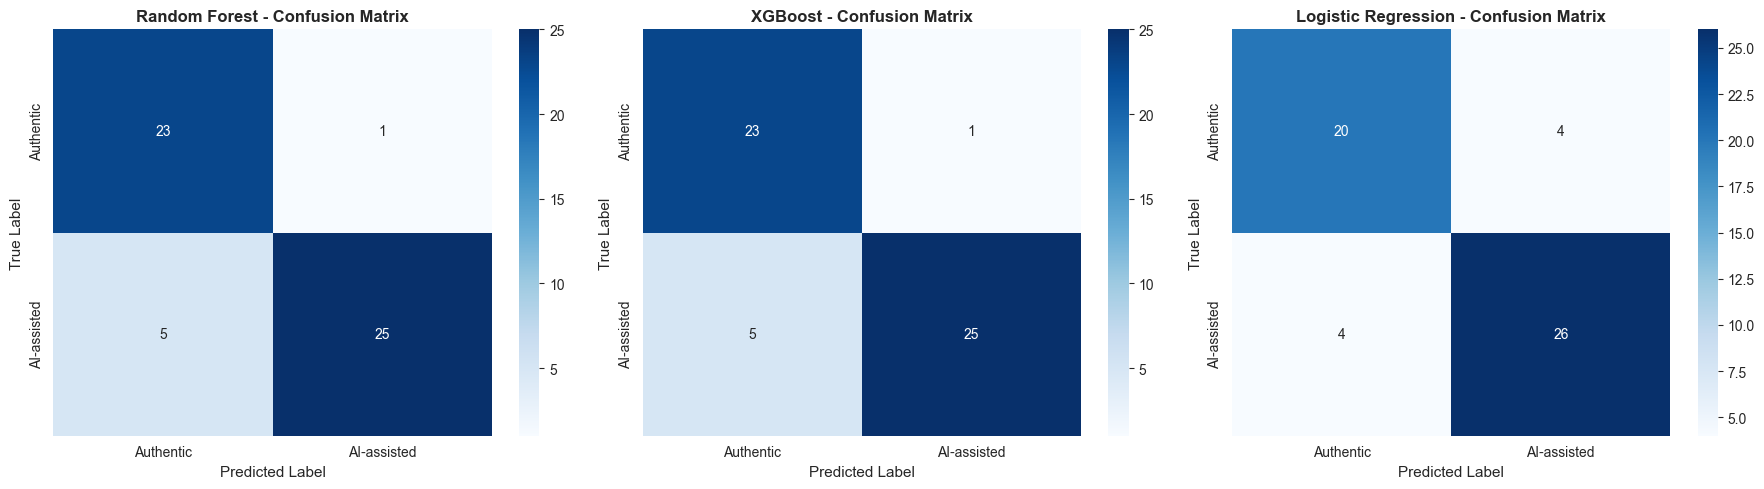

In [25]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_confusion_matrix(y_val_split, y_pred_rf, "Random Forest", ax=axes[0])
plot_confusion_matrix(y_val_split, y_pred_xgb, "XGBoost", ax=axes[1])
plot_confusion_matrix(y_val_split, y_pred_lr, "Logistic Regression", ax=axes[2])

plt.tight_layout()
plt.show()


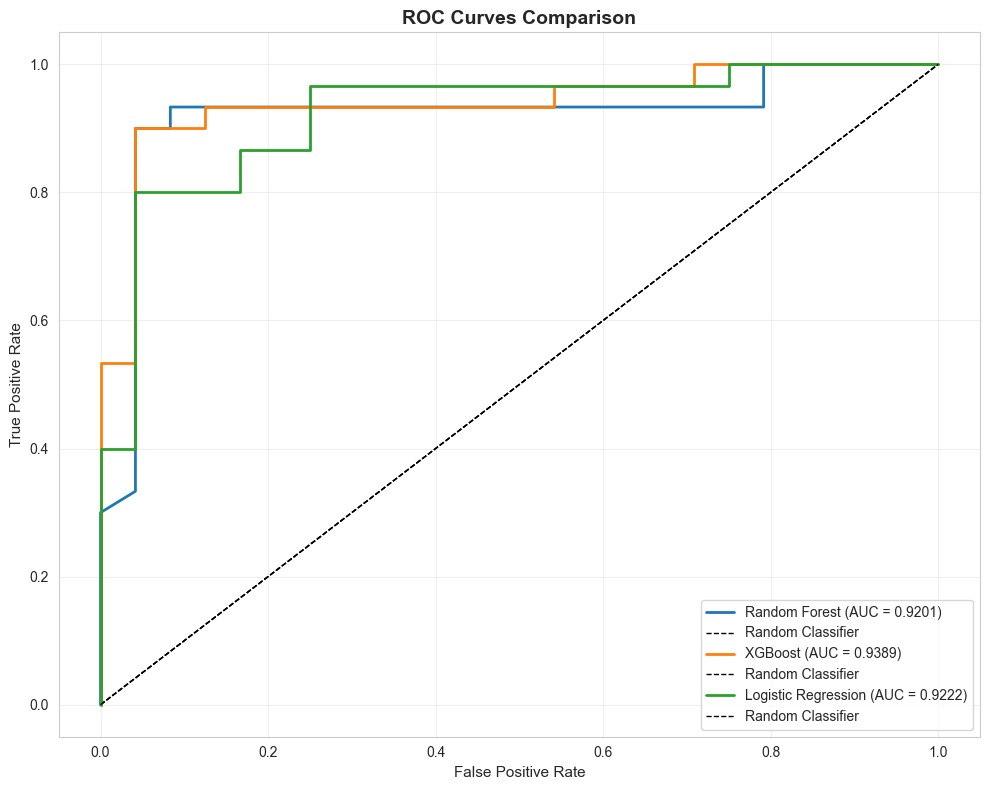

In [26]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

plot_roc_curve(y_val_split, y_pred_proba_rf, "Random Forest", ax=ax)
plot_roc_curve(y_val_split, y_pred_proba_xgb, "XGBoost", ax=ax)
plot_roc_curve(y_val_split, y_pred_proba_lr, "Logistic Regression", ax=ax)

ax.set_title('ROC Curves Comparison', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


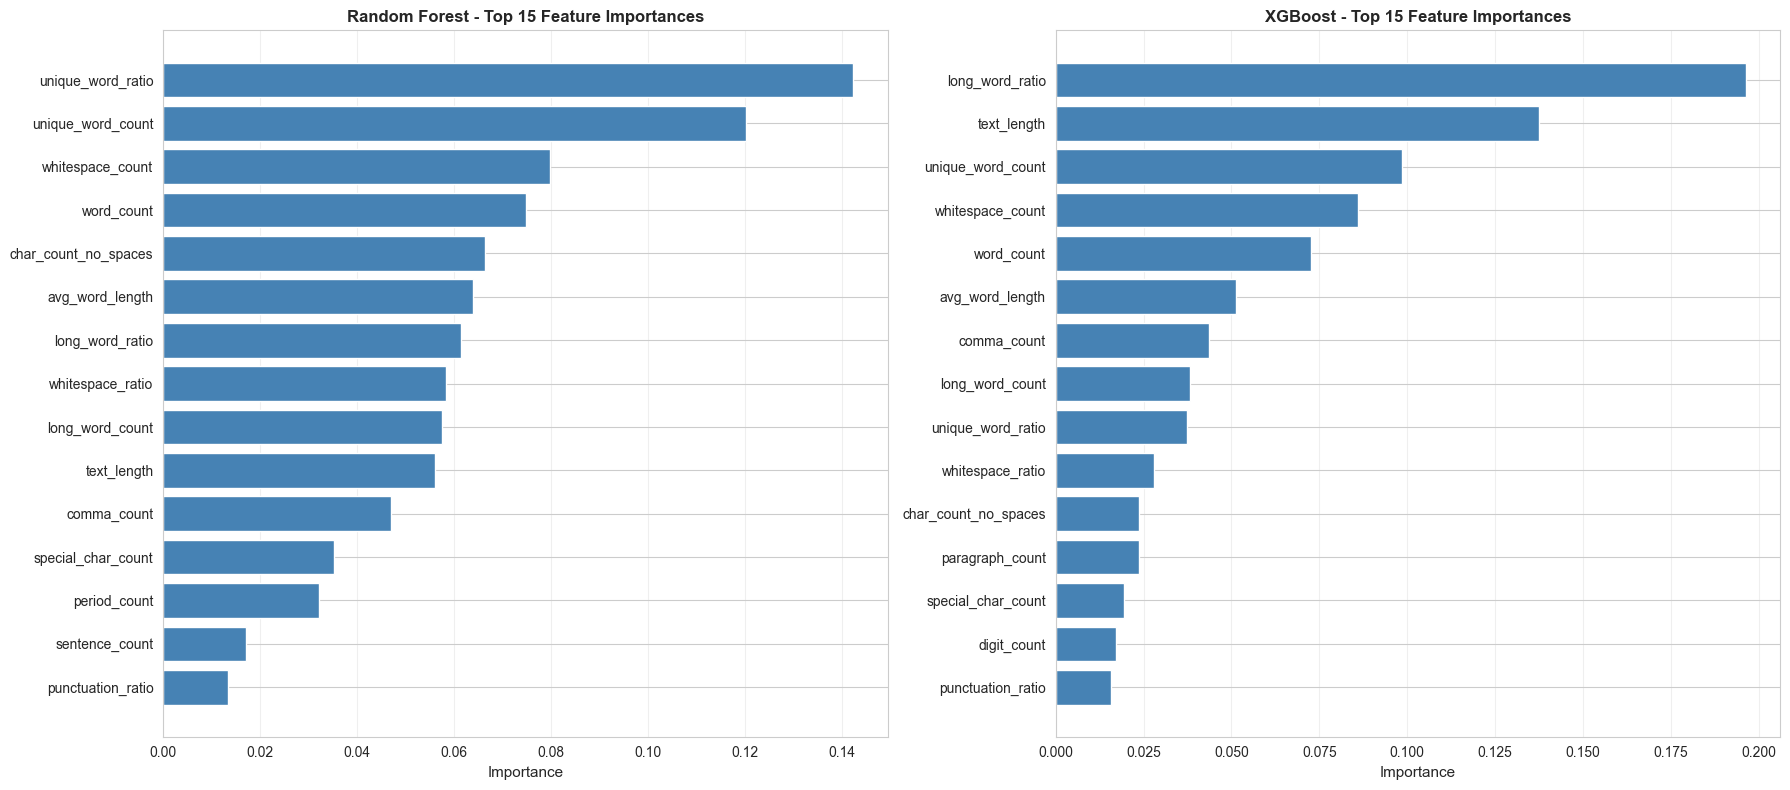

In [27]:
# Feature Importances
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

plot_feature_importance(rf_model, feature_names, "Random Forest", top_n=15, ax=axes[0])
plot_feature_importance(xgb_model, feature_names, "XGBoost", top_n=15, ax=axes[1])

plt.tight_layout()
plt.show()



MODEL COMPARISON
                     accuracy  precision  recall      f1  roc_auc
XGBoost                0.8889     0.9615  0.8333  0.8929   0.9389
Logistic Regression    0.8519     0.8667  0.8667  0.8667   0.9222
Random Forest          0.8889     0.9615  0.8333  0.8929   0.9201


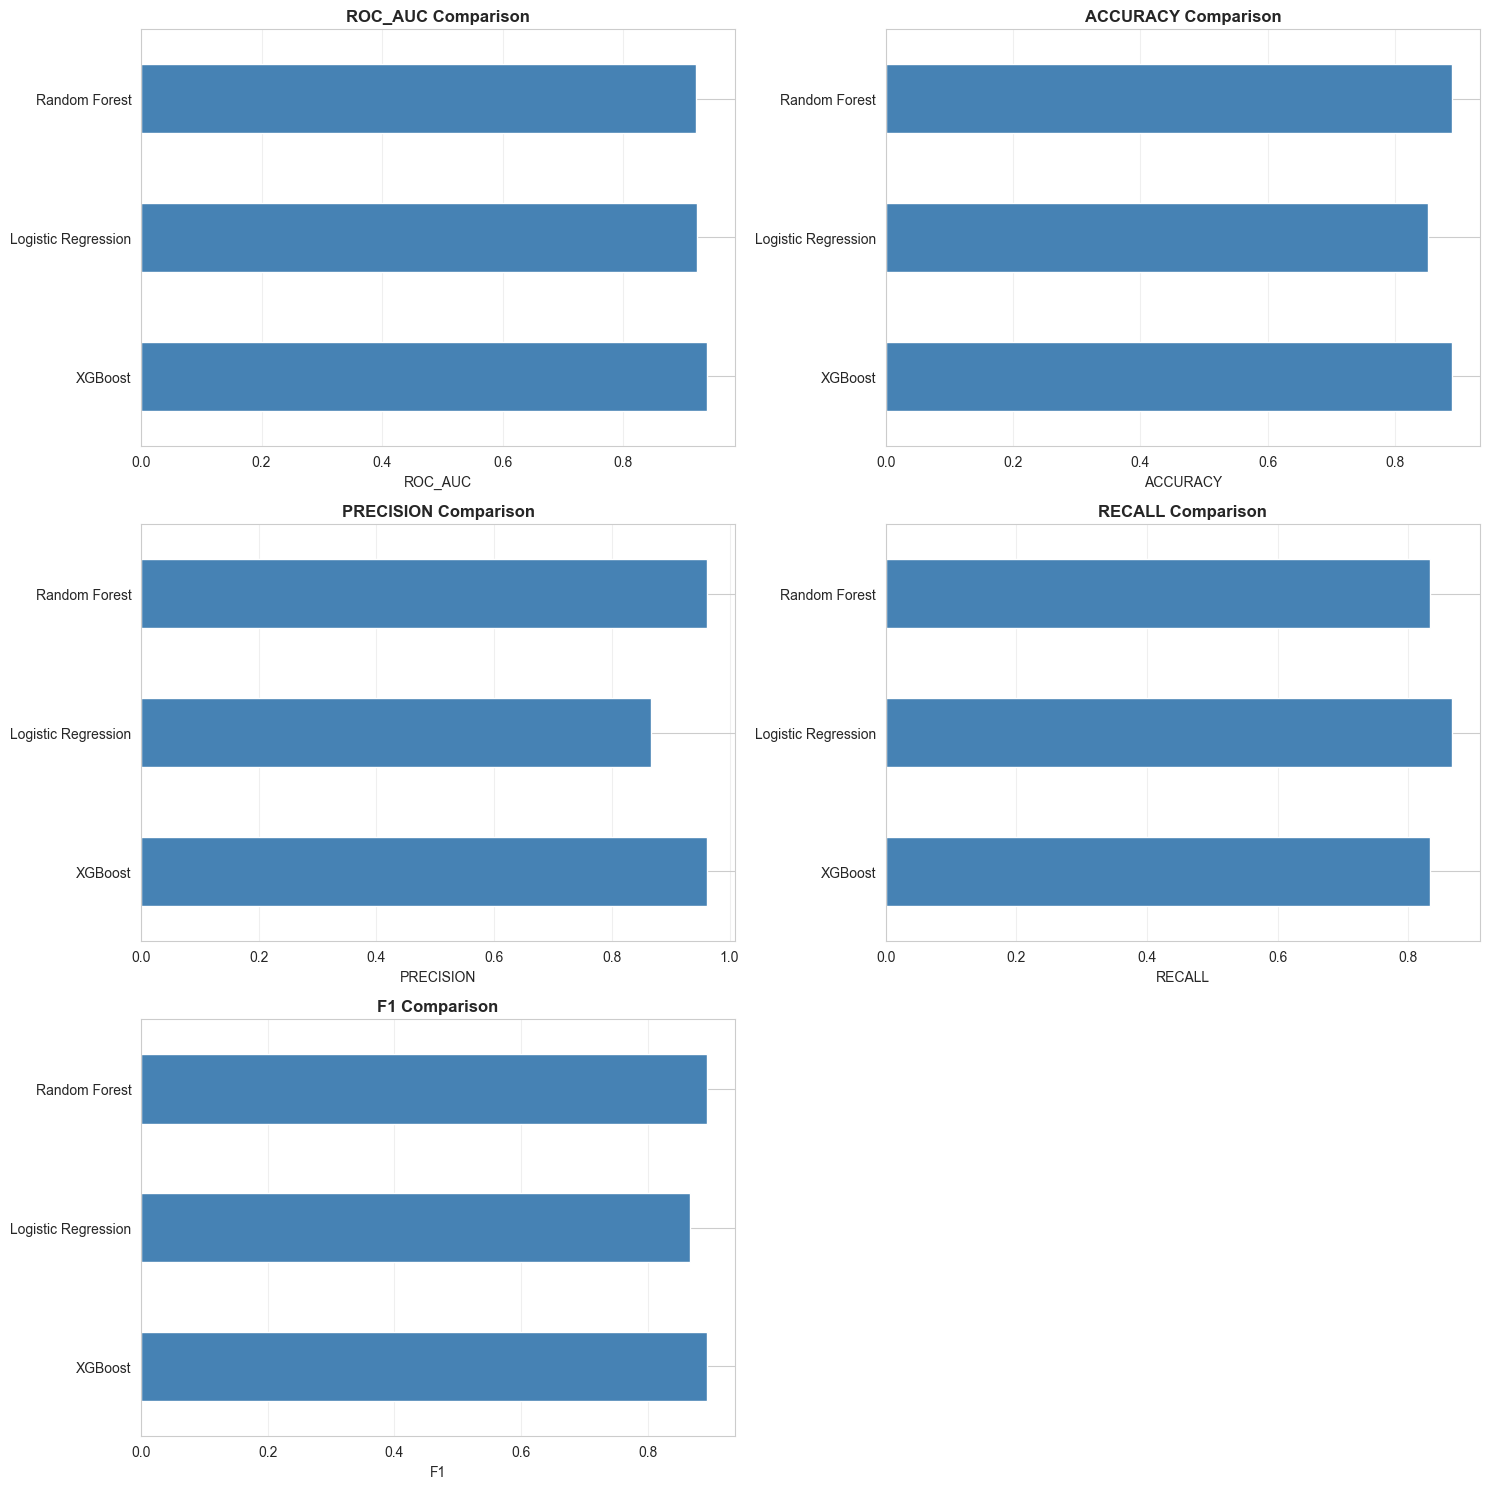

In [28]:
# Model Comparison
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('roc_auc', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

metrics_to_plot = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
for i, metric in enumerate(metrics_to_plot):
    if metric in comparison_df.columns:
        ax = axes[i // 2, i % 2]
        comparison_df[metric].plot(kind='barh', ax=ax, color='steelblue')
        ax.set_title(f'{metric.upper()} Comparison', fontweight='bold')
        ax.set_xlabel(metric.upper())
        ax.grid(axis='x', alpha=0.3)

# Hide the last empty subplot if we have odd number of metrics
if len([m for m in metrics_to_plot if m in comparison_df.columns]) < 6:
    axes[2, 1].axis('off')

plt.tight_layout()
plt.show()


## Generate Predictions on Test Set


In [29]:
# Train best model on full training data
best_model_name = comparison_df.index[0]
print(f"Best model: {best_model_name}")
print(f"ROC-AUC: {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")

# Retrain best model on full training set
if best_model_name == 'Logistic Regression':
    scaler_full = StandardScaler()
    X_train_full_scaled = scaler_full.fit_transform(X_train)
    X_test_scaled = scaler_full.transform(X_test)
    
    best_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
    best_model.fit(X_train_full_scaled, y_train)
    test_predictions = best_model.predict_proba(X_test_scaled)[:, 1]
elif best_model_name == 'XGBoost':
    best_model = xgb.XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'
    )
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict_proba(X_test)[:, 1]
else:  # Random Forest
    best_model = RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    )
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict_proba(X_test)[:, 1]

print(f"\nGenerated predictions for {len(test_predictions)} test samples")


Best model: XGBoost
ROC-AUC: 0.9389

Generated predictions for 264 test samples


In [30]:
# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'is_cheating': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")
print(f"\nSubmission preview:")
print(submission.head(10))
print(f"\nPrediction statistics:")
print(submission['is_cheating'].describe())


Submission file saved as 'submission.csv'

Submission preview:
                 id  is_cheating
0  scr_81822029c661     0.426982
1  scr_52efb19e0ea9     0.992273
2  scr_8fc0f33c559e     0.252559
3  scr_bac3f5d3aa12     0.267407
4  scr_adfbe009984d     0.053054
5  scr_9e08ece19277     0.992095
6  scr_0e34514f3cd4     0.998305
7  scr_b10d808b5528     0.997003
8  scr_2024f1e7bf94     0.834662
9  scr_aa0b11f10fff     0.061381

Prediction statistics:
count    264.000000
mean       0.595356
std        0.426196
min        0.005186
25%        0.083827
50%        0.896884
75%        0.995844
max        0.999011
Name: is_cheating, dtype: float64


## Part 2: Naïve Features + Embeddings (Multimodal)



Here we use NVIDIA's LLama embed nemotron: https://huggingface.co/nvidia/llama-embed-nemotron-8b
We can change this to Google's SOTA embedder if we prefer: https://huggingface.co/blog/embeddinggemma OR Qwen 3 OR older models like BERT

In [31]:
!pip install transformers==4.51.0
!pip install flash-attn==2.6.3

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached flash_attn-2.6.3.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      
      
      torch.__version__  = 2.5.1
      
      
      /private/var/folders/4t/b8mb58417k96y50ykz9_qzlr0000gn/T/pip-install-f1zfgzj1/flash-attn_225c33d21d7c403d9b67da48954070ff/setup.py:95: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/4t/b8mb58417k96y50ykz9_qzlr

In [32]:
# Import data processing module
import sys
sys.path.insert(0, '.')
from data_processing import create_dataset, load_dataset, list_available_datasets


In [33]:
# On a Mac M3 Max, this takes about 10 minutes to run
# Create dataset with embeddings (Meta Features + Embeddings)
# This will extract embeddings using llama-embed-nemotron-8b and combine with meta features
print("="*60)
print("Creating Dataset with Embeddings")
print("="*60)
print("This may take some time as embeddings need to be extracted...")

create_dataset(
    train_df=train,
    test_df=test,
    dataset_name='with_embeddings',
    description='Meta features + llama-embed-nemotron-8b embeddings (multimodal)',
    include_embeddings=True,
    embedding_model="nvidia/llama-embed-nemotron-8b",
    batch_size=8  # Adjust based on your GPU memory
)


Creating Dataset with Embeddings
This may take some time as embeddings need to be extracted...
Loading tokenizer from nvidia/llama-embed-nemotron-8b...
Loading model from nvidia/llama-embed-nemotron-8b...


Loading checkpoint shards: 100%|██████████| 4/4 [00:19<00:00,  4.83s/it]


Model loaded on device: mps
Extracting embeddings for training set...


Extracting embeddings: 100%|██████████| 34/34 [04:27<00:00,  7.88s/it]


Extracting embeddings for test set...


Extracting embeddings: 100%|██████████| 33/33 [05:40<00:00, 10.31s/it]


✓ Dataset 'with_embeddings' created successfully!
  Description: Meta features + llama-embed-nemotron-8b embeddings (multimodal)
  Features: 4121
  - Meta features: all
  - Embeddings: 4096 dims (nvidia/llama-embed-nemotron-8b)
  Train samples: 269
  Test samples: 264
  Saved to: /Users/hindy/Desktop/Academics/MIT/MIT MBAn/Machine Learning under a Modern Optimization Lens/Mercor-AI-detection/processed_data/with_embeddings


{'dataset_name': 'with_embeddings',
 'description': 'Meta features + llama-embed-nemotron-8b embeddings (multimodal)',
 'feature_names': ['text_length',
  'word_count',
  'char_count_no_spaces',
  'sentence_count',
  'paragraph_count',
  'avg_word_length',
  'avg_sentence_length',
  'exclamation_count',
  'question_count',
  'comma_count',
  'period_count',
  'punctuation_ratio',
  'uppercase_count',
  'uppercase_ratio',
  'digit_count',
  'special_char_count',
  'long_word_count',
  'long_word_ratio',
  'first_person_pronouns',
  'first_person_ratio',
  'whitespace_count',
  'whitespace_ratio',
  'unique_word_count',
  'unique_word_ratio',
  'topic_encoded',
  'embedding_0',
  'embedding_1',
  'embedding_2',
  'embedding_3',
  'embedding_4',
  'embedding_5',
  'embedding_6',
  'embedding_7',
  'embedding_8',
  'embedding_9',
  'embedding_10',
  'embedding_11',
  'embedding_12',
  'embedding_13',
  'embedding_14',
  'embedding_15',
  'embedding_16',
  'embedding_17',
  'embedding_18',


In [36]:
# Load the dataset with embeddings
X_train_emb, y_train_emb, X_test_emb, info_emb = load_dataset('with_embeddings')

print(f"\nDataset loaded successfully!")
print(f"Total features: {info_emb['n_features']}")
print(f"Meta features: {len([f for f in info_emb['feature_names'] if not f.startswith('embedding_')])}")
print(f"Embedding dimensions: {info_emb.get('embedding_info', {}).get('embedding_dim', 0)}")
print(f"Train samples: {info_emb['n_train_samples']}")
print(f"Test samples: {info_emb['n_test_samples']}")
print(f"\nFirst few feature names:")
for i, name in enumerate(info_emb['feature_names'][:10], 1):
    print(f"  {i}. {name}")
if len(info_emb['feature_names']) > 10:
    print(f"  ... and {len(info_emb['feature_names']) - 10} more features")



Dataset loaded successfully!
Total features: 4121
Meta features: 25
Embedding dimensions: 4096
Train samples: 269
Test samples: 264

First few feature names:
  1. text_length
  2. word_count
  3. char_count_no_spaces
  4. sentence_count
  5. paragraph_count
  6. avg_word_length
  7. avg_sentence_length
  8. exclamation_count
  9. question_count
  10. comma_count
  ... and 4111 more features


In [ ]:
# Let us train a simple logistic regression model on this dataset

# Split the dataset into training and validation sets
X_train_emb, X_val_emb, y_train_emb, y_val_emb = train_test_split(
    X_train_emb, y_train_emb, test_size=0.2, random_state=42, stratify=y_train_emb
)

# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# Train the model
model.fit(X_train_emb, y_train_emb)

# Make predictions on the validation set
y_pred_emb = model.predict(X_val_emb)

# Evaluate the model accuracy and auc score
accuracy = accuracy_score(y_val_emb, y_pred_emb)
auc_score = roc_auc_score(y_val_emb, y_pred_emb)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")



Accuracy: 0.9259
AUC Score: 0.9250


In [40]:
# Let's train an XGBoost model on this dataset

# Initialize the model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train_emb, y_train_emb)

# Make predictions on the validation set
y_pred_xgb = xgb_model.predict(X_val_emb)

# Evaluate the model accuracy and auc score
accuracy = accuracy_score(y_val_emb, y_pred_xgb)
auc_score = roc_auc_score(y_val_emb, y_pred_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")


Accuracy: 0.9444
AUC Score: 0.9458


In [42]:
# Import PyTorch for neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [60]:
# We train a simple neural network on this dataset

# Convert numpy arrays to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_tensor = torch.FloatTensor(X_train_emb).to(device)
y_train_tensor = torch.FloatTensor(y_train_emb.reshape(-1, 1)).to(device)
X_val_tensor = torch.FloatTensor(X_val_emb).to(device)
y_val_tensor = torch.FloatTensor(y_val_emb.reshape(-1, 1)).to(device)

# Initialize the model
nn_model = nn.Sequential(
    nn.Linear(info_emb['n_features'], 100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(50, 1),
    nn.Sigmoid()  # Sigmoid for binary classification
).to(device)

# Print model architecture summary
print("\n" + "="*60)
print("NEURAL NETWORK ARCHITECTURE SUMMARY")
print("="*60)
print(f"Input Features: {info_emb['n_features']}")
print(f"  - Meta features: {len([f for f in info_emb['feature_names'] if not f.startswith('embedding_')])}")
print(f"  - Embedding dimensions: {info_emb.get('embedding_info', {}).get('embedding_dim', 0)}")
print("\nArchitecture:")
print("  Layer 1: Linear(input_dim -> 100)")
print("  Activation: ReLU")
print("  Dropout: 0.3")
print("  Layer 2: Linear(100 -> 50)")
print("  Activation: ReLU")
print("  Dropout: 0.3")
print("  Layer 3: Linear(50 -> 1)")
print("  Activation: Sigmoid")
print(f"\nTotal Parameters: {sum(p.numel() for p in nn_model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in nn_model.parameters() if p.requires_grad):,}")
print("="*60)

# Define the loss function and optimizer
criterion = nn.BCELoss()

# Use AdamW with weight decay for better regularization and stability
# Lower learning rate for smoother updates
initial_lr = 0.0005  # Reduced from 0.001 for smoother curves
optimizer = optim.AdamW(nn_model.parameters(), lr=initial_lr, weight_decay=1e-4)

# Learning rate scheduler - reduces LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True, min_lr=1e-6
)

# Train the model with validation tracking
n_epochs = 40
batch_size = 64  # Increased batch size for smoother gradients (less noise)

# Create data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Track training and validation loss
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

# Exponential moving average for smoother curves (optional smoothing)
ema_alpha = 0.1  # Smoothing factor (0 = no smoothing, 1 = no change)
ema_train_loss = None
ema_val_loss = None
ema_train_acc = None
ema_val_acc = None

print(f"\nTraining neural network for {n_epochs} epochs...")
print(f"Optimizer: AdamW (lr={initial_lr}, weight_decay=1e-4)")
print(f"Batch size: {batch_size}")
print(f"Learning rate scheduler: ReduceLROnPlateau")
print(f"Gradient clipping: enabled (max_norm=1.0)")
print("-" * 60)

for epoch in range(n_epochs):
    # Training phase
    nn_model.train()
    epoch_train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # Gradient clipping for stability (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(nn_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        epoch_train_loss += loss.item()
        
        # Calculate training accuracy
        predicted = (outputs >= 0.5).float()
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    
    # Validation phase
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        
        # Calculate validation accuracy
        val_predicted = (val_outputs >= 0.5).float()
        val_correct = (val_predicted == y_val_tensor).sum().item()
        val_accuracy = val_correct / len(y_val_tensor)
    
    # Update learning rate scheduler based on validation loss
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Apply exponential moving average for smoother curves
    if ema_train_loss is None:
        ema_train_loss = avg_train_loss
        ema_val_loss = val_loss
        ema_train_acc = train_accuracy
        ema_val_acc = val_accuracy
    else:
        ema_train_loss = ema_alpha * avg_train_loss + (1 - ema_alpha) * ema_train_loss
        ema_val_loss = ema_alpha * val_loss + (1 - ema_alpha) * ema_val_loss
        ema_train_acc = ema_alpha * train_accuracy + (1 - ema_alpha) * ema_train_acc
        ema_val_acc = ema_alpha * val_accuracy + (1 - ema_alpha) * ema_val_acc
    
    # Store both raw and smoothed metrics
    train_losses.append(ema_train_loss)
    val_losses.append(ema_val_loss)
    train_accuracies.append(ema_train_acc)
    val_accuracies.append(ema_val_acc)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] | LR: {current_lr:.6f}")
        print(f"  Train Loss: {avg_train_loss:.4f} (smoothed: {ema_train_loss:.4f}), Train Acc: {train_accuracy:.4f} (smoothed: {ema_train_acc:.4f})")
        print(f"  Val Loss: {val_loss:.4f} (smoothed: {ema_val_loss:.4f}), Val Acc: {val_accuracy:.4f} (smoothed: {ema_val_acc:.4f})")

# Make predictions on the validation set
nn_model.eval()
with torch.no_grad():
    y_pred_proba = nn_model(X_val_tensor).cpu().numpy().flatten()
    y_pred_nn = (y_pred_proba >= 0.5).astype(int)

# Evaluate the model accuracy and auc score
accuracy = accuracy_score(y_val_emb, y_pred_nn)
auc_score = roc_auc_score(y_val_emb, y_pred_proba)

print(f"\n" + "="*60)
print("FINAL NEURAL NETWORK RESULTS")
print("="*60)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation AUC Score: {auc_score:.4f}")
print("="*60)


Using device: mps

NEURAL NETWORK ARCHITECTURE SUMMARY
Input Features: 4121
  - Meta features: 25
  - Embedding dimensions: 4096

Architecture:
  Layer 1: Linear(input_dim -> 100)
  Activation: ReLU
  Dropout: 0.3
  Layer 2: Linear(100 -> 50)
  Activation: ReLU
  Dropout: 0.3
  Layer 3: Linear(50 -> 1)
  Activation: Sigmoid

Total Parameters: 417,301
Trainable Parameters: 417,301

Training neural network for 40 epochs...
Optimizer: AdamW (lr=0.0005, weight_decay=1e-4)
Batch size: 64
Learning rate scheduler: ReduceLROnPlateau
Gradient clipping: enabled (max_norm=1.0)
------------------------------------------------------------
Epoch [20/40] | LR: 0.000500
  Train Loss: 0.4960 (smoothed: 0.6981), Train Acc: 0.7395 (smoothed: 0.6755)
  Val Loss: 0.5180 (smoothed: 0.5811), Val Acc: 0.7963 (smoothed: 0.7239)
Epoch [40/40] | LR: 0.000500
  Train Loss: 0.2880 (smoothed: 0.4066), Train Acc: 0.9023 (smoothed: 0.8439)
  Val Loss: 0.3155 (smoothed: 0.4110), Val Acc: 0.8519 (smoothed: 0.8376)

FIN

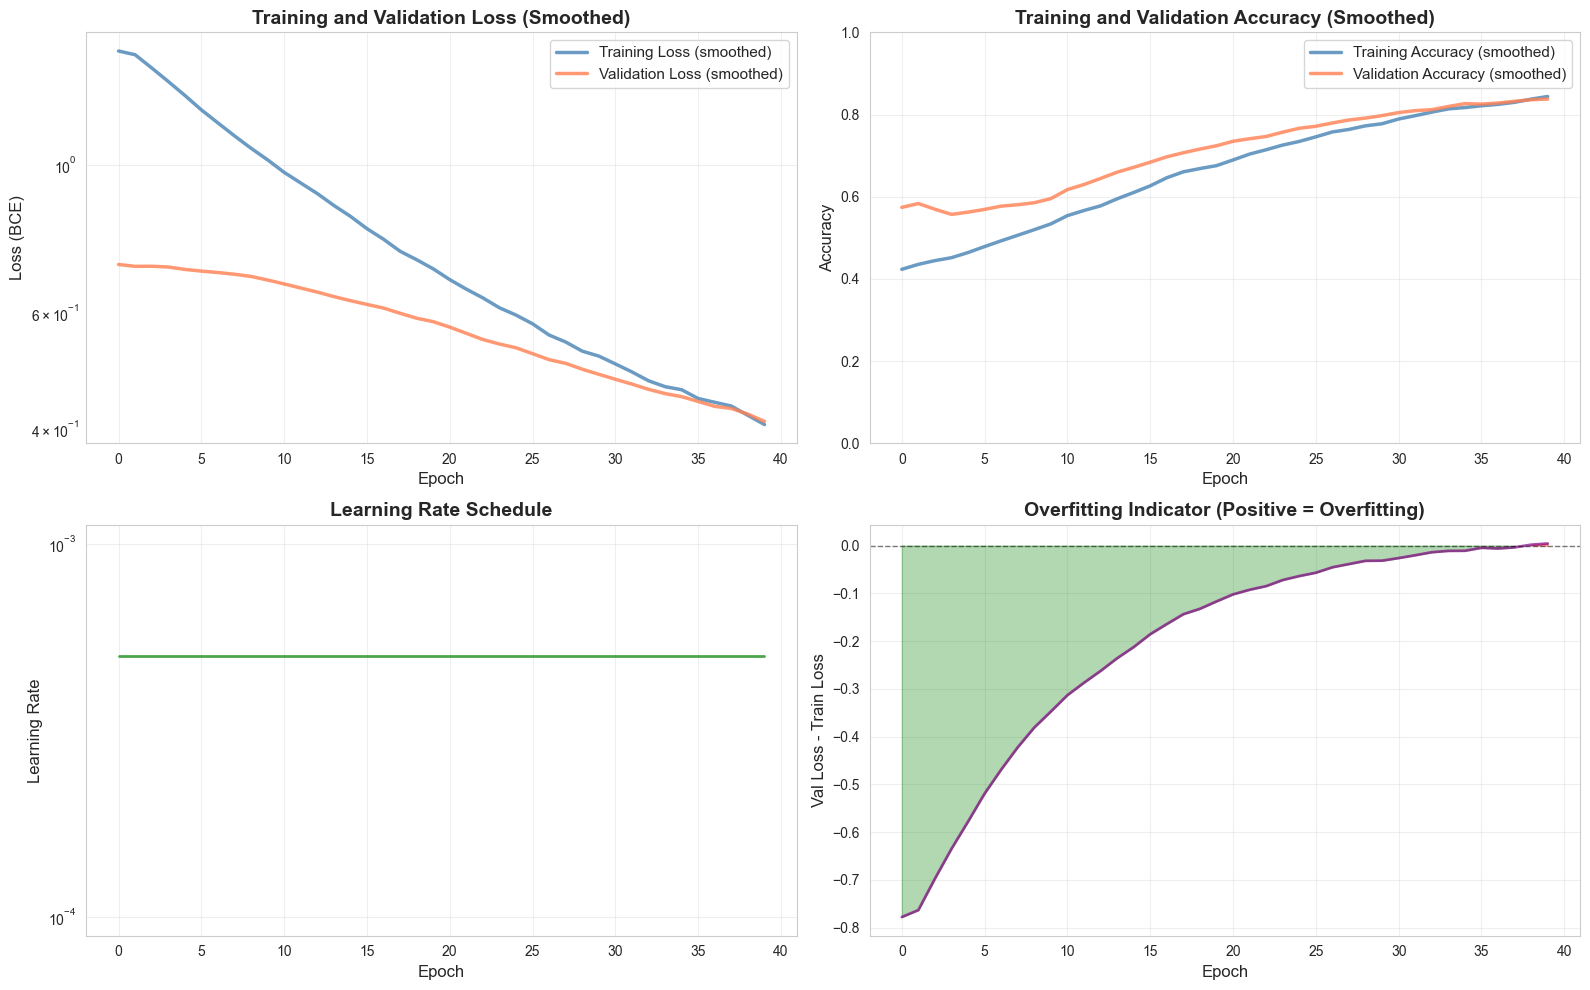

In [61]:
# Plot training curves to check for overfitting
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot loss curves (smoothed)
axes[0, 0].plot(train_losses, label='Training Loss (smoothed)', linewidth=2.5, color='steelblue', alpha=0.8)
axes[0, 0].plot(val_losses, label='Validation Loss (smoothed)', linewidth=2.5, color='coral', alpha=0.8)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss (BCE)', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss (Smoothed)', fontweight='bold', fontsize=14)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_yscale('log')  # Log scale for better visualization

# Plot accuracy curves (smoothed)
axes[0, 1].plot(train_accuracies, label='Training Accuracy (smoothed)', linewidth=2.5, color='steelblue', alpha=0.8)
axes[0, 1].plot(val_accuracies, label='Validation Accuracy (smoothed)', linewidth=2.5, color='coral', alpha=0.8)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy (Smoothed)', fontweight='bold', fontsize=14)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Plot learning rate schedule
axes[1, 0].plot(learning_rates, linewidth=2, color='green', alpha=0.7)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('Learning Rate Schedule', fontweight='bold', fontsize=14)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_yscale('log')

# Plot loss difference (overfitting indicator)
loss_diff = [v - t for t, v in zip(train_losses, val_losses)]
axes[1, 1].plot(loss_diff, linewidth=2, color='purple', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Val Loss - Train Loss', fontsize=12)
axes[1, 1].set_title('Overfitting Indicator (Positive = Overfitting)', fontweight='bold', fontsize=14)
axes[1, 1].grid(alpha=0.3)
axes[1, 1].fill_between(range(len(loss_diff)), 0, loss_diff, alpha=0.3, color='red', where=[x > 0 for x in loss_diff])
axes[1, 1].fill_between(range(len(loss_diff)), 0, loss_diff, alpha=0.3, color='green', where=[x <= 0 for x in loss_diff])

plt.tight_layout()
plt.show()


In [64]:
# Reload data_processing module if needed (run this if you get import errors)
import importlib
import sys

# Remove data_processing from cache if it exists
if 'data_processing' in sys.modules:
    importlib.reload(sys.modules['data_processing'])
if 'data_processing.subset_selection' in sys.modules:
    importlib.reload(sys.modules['data_processing.subset_selection'])

print("Module cache cleared. Ready to import subset_selection functions.")


Module cache cleared. Ready to import subset_selection functions.


Before any kind of tuning and further model improvements, let us try to train on the hardest subset of the data using hardest subset selection. 

In [65]:
# Import subset selection functions
# Try importing from the module directly
import sys
import importlib

try:
    from data_processing.subset_selection import (
        select_hardest_subset, 
        apply_subset_selection, 
        identify_hard_samples
    )
    print("✓ Successfully imported from data_processing.subset_selection")
except ImportError as e:
    print(f"⚠ Import error: {e}")
    print("Trying alternative import...")
    # Alternative: import the module and access functions
    import data_processing.subset_selection as subset_sel
    select_hardest_subset = subset_sel.select_hardest_subset
    apply_subset_selection = subset_sel.apply_subset_selection
    identify_hard_samples = subset_sel.identify_hard_samples
    print("✓ Successfully imported using alternative method")

print("\n" + "="*60)
print("HARDEST SUBSET SELECTION")
print("="*60)
print("\nThis will select the hardest/most informative training samples")
print("using optimization-based subset selection (similar to Julia IAI/Gurobi approach).")
print("\nMethods available:")
print("  1. Optimization-based (trimmed loss) - requires Gurobi or scipy")
print("  2. Prediction error-based (simple, fast)")
print("  3. Confidence-based (low confidence samples)")
print("  4. Margin-based (samples near decision boundary)")
print("="*60)


✓ Successfully imported from data_processing.subset_selection

HARDEST SUBSET SELECTION

This will select the hardest/most informative training samples
using optimization-based subset selection (similar to Julia IAI/Gurobi approach).

Methods available:
  1. Optimization-based (trimmed loss) - requires Gurobi or scipy
  2. Prediction error-based (simple, fast)
  3. Confidence-based (low confidence samples)
  4. Margin-based (samples near decision boundary)


In [66]:
# Method 1: Simple prediction error-based selection (fast, no optimization solver needed)
# Select 70% hardest samples based on prediction errors

print("\nMethod 1: Prediction Error-Based Selection")
print("-" * 60)

# Use the dataset with embeddings we already have
# X_train_emb, y_train_emb are from Part 2

# First, train a simple model to identify hard samples
from sklearn.linear_model import LogisticRegression

temp_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
temp_model.fit(X_train_emb, y_train_emb)

# Identify hardest samples
hardest_mask, _ = select_hardest_subset(
    X_train_emb, 
    y_train_emb,
    method='prediction_error',
    m_ratio=0.7,  # Select 70% hardest samples
    verbose=True
)

X_train_hard = X_train_emb[hardest_mask]
y_train_hard = y_train_emb[hardest_mask]

print(f"\nSelected {len(X_train_hard)} hardest samples out of {len(X_train_emb)}")
print(f"Class distribution in selected subset:")
unique, counts = np.unique(y_train_hard, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} ({count/len(y_train_hard)*100:.1f}%)")



Method 1: Prediction Error-Based Selection
------------------------------------------------------------
Using prediction_error method for subset selection...

Selected 151 hardest samples out of 215
Class distribution in selected subset:
  Class 0: 66 (43.7%)
  Class 1: 85 (56.3%)


In [67]:
# Method 2: Try optimization-based selection if Gurobi or scipy is available
# This implements the trimmed loss approach similar to your Julia code

print("\n" + "="*60)
print("Method 2: Optimization-Based Selection (Trimmed Loss)")
print("="*60)

try:
    # Try to use optimization-based selection
    hardest_mask_opt, beta_coef = select_hardest_subset(
        X_train_emb,
        y_train_emb,
        method='optimization',
        m_ratio=0.7,
        lambda_reg=0.1,
        use_gurobi=False,  # Set to True if you have Gurobi installed
        verbose=True
    )
    
    X_train_hard_opt = X_train_emb[hardest_mask_opt]
    y_train_hard_opt = y_train_emb[hardest_mask_opt]
    
    print(f"\n✓ Optimization-based selection successful!")
    print(f"Selected {len(X_train_hard_opt)} samples")
    if beta_coef is not None:
        print(f"Model coefficients shape: {beta_coef.shape}")
    
    # Use optimization-based selection
    use_optimization = True
    X_train_selected = X_train_hard_opt
    y_train_selected = y_train_hard_opt
    
except Exception as e:
    print(f"\n⚠ Optimization-based selection not available: {e}")
    print("Falling back to prediction error-based selection...")
    use_optimization = False
    X_train_selected = X_train_hard
    y_train_selected = y_train_hard



Method 2: Optimization-Based Selection (Trimmed Loss)
Using scipy.optimize for optimization-based subset selection...

✓ Optimization-based selection successful!
Selected 151 samples
Model coefficients shape: (4121,)


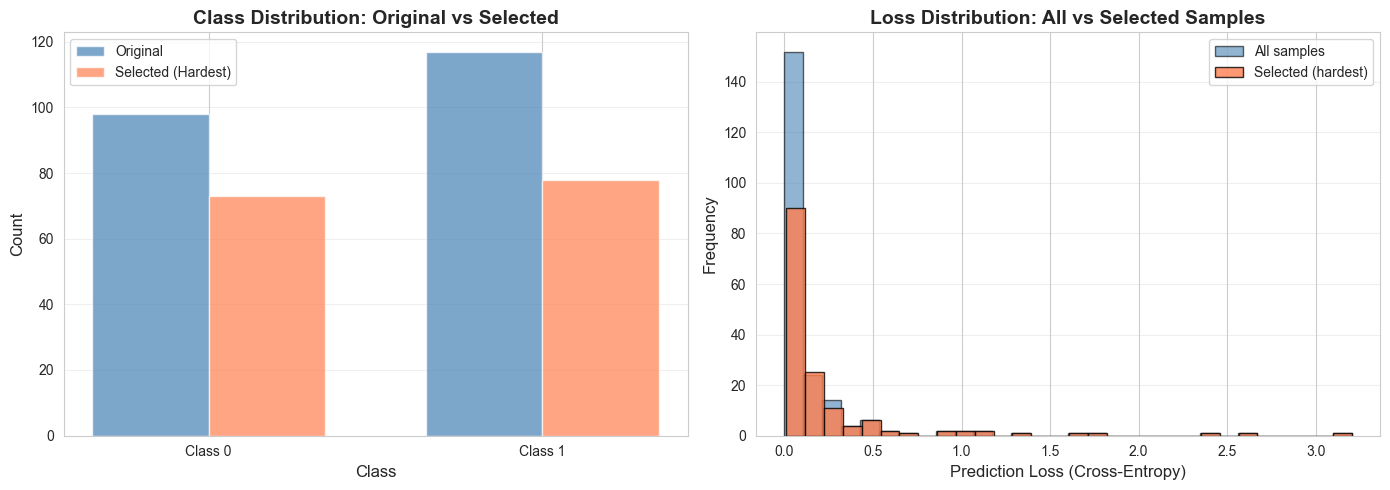


Summary Statistics:
  Mean loss (all samples): 0.1732
  Mean loss (selected): 0.2447
  Median loss (all samples): 0.0456
  Median loss (selected): 0.0900


In [68]:
# Visualize the difference between original and selected subsets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sample distribution by class
original_counts = [np.sum(y_train_emb == 0), np.sum(y_train_emb == 1)]
selected_counts = [np.sum(y_train_selected == 0), np.sum(y_train_selected == 1)]

x = np.arange(2)
width = 0.35

axes[0].bar(x - width/2, original_counts, width, label='Original', color='steelblue', alpha=0.7)
axes[0].bar(x + width/2, selected_counts, width, label='Selected (Hardest)', color='coral', alpha=0.7)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Class Distribution: Original vs Selected', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Class 0', 'Class 1'])
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Plot 2: Prediction errors distribution
temp_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
temp_model.fit(X_train_emb, y_train_emb)
y_pred_proba = temp_model.predict_proba(X_train_emb)
losses = [-np.log(y_pred_proba[i, int(y_train_emb[i])]) for i in range(len(X_train_emb))]

axes[1].hist(losses, bins=30, alpha=0.6, color='steelblue', label='All samples', edgecolor='black')
axes[1].hist([losses[i] for i in range(len(losses)) if hardest_mask[i]], bins=30, 
             alpha=0.8, color='coral', label='Selected (hardest)', edgecolor='black')
axes[1].set_xlabel('Prediction Loss (Cross-Entropy)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Loss Distribution: All vs Selected Samples', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nSummary Statistics:")
print(f"  Mean loss (all samples): {np.mean(losses):.4f}")
print(f"  Mean loss (selected): {np.mean([losses[i] for i in range(len(losses)) if hardest_mask[i]]):.4f}")
print(f"  Median loss (all samples): {np.median(losses):.4f}")
print(f"  Median loss (selected): {np.median([losses[i] for i in range(len(losses)) if hardest_mask[i]]):.4f}")


In [69]:
# Now train models on the hardest subset and compare performance

print("\n" + "="*60)
print("TRAINING MODELS ON HARDEST SUBSET")
print("="*60)

# Split selected data into train/val
from sklearn.model_selection import train_test_split

X_train_hard_split, X_val_hard_split, y_train_hard_split, y_val_hard_split = train_test_split(
    X_train_selected, y_train_selected, test_size=0.2, random_state=42, stratify=y_train_selected
)

print(f"\nTraining on hardest subset:")
print(f"  Train samples: {len(X_train_hard_split)}")
print(f"  Val samples: {len(X_val_hard_split)}")

# Train Logistic Regression on hardest subset
lr_hard = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_hard.fit(X_train_hard_split, y_train_hard_split)

y_pred_hard = lr_hard.predict(X_val_hard_split)
y_pred_proba_hard = lr_hard.predict_proba(X_val_hard_split)[:, 1]

acc_hard = accuracy_score(y_val_hard_split, y_pred_hard)
auc_hard = roc_auc_score(y_val_hard_split, y_pred_proba_hard)

print(f"\nLogistic Regression (Hardest Subset):")
print(f"  Accuracy: {acc_hard:.4f}")
print(f"  AUC: {auc_hard:.4f}")

# Compare with model trained on all data (from Part 2)
# Assuming we have X_val_emb and y_val_emb from earlier
print(f"\nComparison with model trained on ALL data:")
print(f"  Accuracy (all data): {accuracy:.4f}")
print(f"  AUC (all data): {auc_score:.4f}")
print(f"\n  Accuracy (hardest subset): {acc_hard:.4f}")
print(f"  AUC (hardest subset): {auc_hard:.4f}")
print(f"\n  Improvement: Acc={acc_hard-accuracy:+.4f}, AUC={auc_hard-auc_score:+.4f}")



TRAINING MODELS ON HARDEST SUBSET

Training on hardest subset:
  Train samples: 120
  Val samples: 31

Logistic Regression (Hardest Subset):
  Accuracy: 0.8387
  AUC: 0.7917

Comparison with model trained on ALL data:
  Accuracy (all data): 0.8519
  AUC (all data): 0.9472

  Accuracy (hardest subset): 0.8387
  AUC (hardest subset): 0.7917

  Improvement: Acc=-0.0131, AUC=-0.1556


In [70]:
# Train XGBoost on hardest subset
print("\n" + "-"*60)
print("Training XGBoost on hardest subset...")

xgb_hard = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_hard.fit(X_train_hard_split, y_train_hard_split)
y_pred_xgb_hard = xgb_hard.predict(X_val_hard_split)
y_pred_proba_xgb_hard = xgb_hard.predict_proba(X_val_hard_split)[:, 1]

acc_xgb_hard = accuracy_score(y_val_hard_split, y_pred_xgb_hard)
auc_xgb_hard = roc_auc_score(y_val_hard_split, y_pred_proba_xgb_hard)

print(f"\nXGBoost (Hardest Subset):")
print(f"  Accuracy: {acc_xgb_hard:.4f}")
print(f"  AUC: {auc_xgb_hard:.4f}")

# Compare with XGBoost on all data (from Part 2)
print(f"\nComparison:")
print(f"  XGBoost (all data): Acc={accuracy_score(y_val_emb, y_pred_xgb):.4f}, AUC={roc_auc_score(y_val_emb, y_pred_xgb):.4f}")
print(f"  XGBoost (hardest subset): Acc={acc_xgb_hard:.4f}, AUC={auc_xgb_hard:.4f}")



------------------------------------------------------------
Training XGBoost on hardest subset...

XGBoost (Hardest Subset):
  Accuracy: 0.8387
  AUC: 0.9083

Comparison:
  XGBoost (all data): Acc=0.9444, AUC=0.9458
  XGBoost (hardest subset): Acc=0.8387, AUC=0.9083


At first sight, hardest subset selection seems to lower performance. Maybe we should be testing this on a larger scale dataset with more diversity of obserations (more similar to real life and potential the hidden test set). 